# 天池新人赛 【挖掘幸福感】

幸福感是一个古老而深刻的话题，是人类世代追求的方向。与幸福感相关的因素成千上万、因人而异，大如国计民生，小如路边烤红薯，都会对幸福感产生影响。这些错综复杂的因素中，我们能找到其中的共性，一窥幸福感的要义吗？

-1 = 不适用; -2 = 不知道; -3 = 拒绝回答; -8 = 无法回答;


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('./input/happiness_train_complete.csv', encoding='gbk', index_col=0)
test = pd.read_csv('./input/happiness_test_complete.csv', encoding='gbk', index_col=0)

In [3]:
train.shape, test.shape

((8000, 139), (2968, 138))

## 特征分析

### 1、happiness
简单查看一下幸福指数的情况

In [4]:
train['happiness'].value_counts()

 4    4818
 5    1410
 3    1159
 2     497
 1     104
-8      12
Name: happiness, dtype: int64

绝大部分人的幸福指数为4，数据当中有 -8：无法回答，为了增加后面工作的准确性，减少噪声的干扰，将 happiness = -8 的数据删除。删除后查看一下人均幸福指数

In [5]:
train.drop(train[train['happiness']==-8].index, inplace=True)

In [6]:
train['happiness'].mean()

3.8679268903355033

总体来说，人均幸福指数有3.85左右，程度大概为中上水平。

### 2、gender

分析一下性别与幸福指数之间的关系

In [7]:
train['gender'].value_counts()

2    4236
1    3752
Name: gender, dtype: int64

In [8]:
train.groupby('gender')['gender', 'happiness'].mean()

,gender,happiness
gender,,
1,1.0,3.853412
2,2.0,3.880784


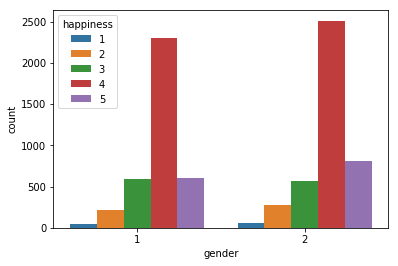

In [9]:
sns.countplot('gender',hue='happiness',data=train)

从表格与图像来看，幸福感和性别的关系并不大

### 3、survey_type

In [10]:
train['survey_type'].value_counts()

1    4745
2    3243
Name: survey_type, dtype: int64

In [11]:
train[['survey_type', 'happiness']].groupby('survey_type').mean()

,happiness
survey_type,
1,3.890832
2,3.834413


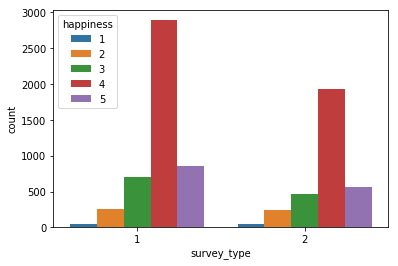

In [12]:
sns.countplot('survey_type', hue='happiness', data=train)

调查数据中城市的基数要比农村的基数大，虽然平均幸福指数都很接近，但城市要比农村的高一点。

## 特征处理

在此之前，先将happiness提取出来，并将训练集和测试集合并。由于数据中存在负数，为了减小它们的干扰，将其置为空。

In [13]:
y_train = train.pop('happiness')
data = pd.concat((train, test), axis=0)
data.shape

(10956, 138)

In [14]:
data[data == -1] = np.nan
data[data == -2] = np.nan
data[data == -3] = np.nan
data[data == -8] = np.nan

In [15]:
data.drop(['city', 'county'], axis=1, inplace=True)

查看一下缺失值情况。

In [16]:
for i in data.columns:
    if data.isnull().sum()[i] != 0:
        print({i: data.isnull().sum()[i]})

{'nationality': 20}
{'religion': 142}
{'religion_freq': 22}
{'edu': 17}
{'edu_other': 10950}
{'edu_status': 1605}
{'edu_yr': 4427}
{'income': 598}
{'political': 45}
{'join_party': 9951}
{'property_other': 10867}
{'health': 5}
{'health_problem': 50}
{'depression': 24}
{'hukou_loc': 4}
{'media_1': 1}
{'media_2': 3}
{'media_3': 3}
{'media_4': 3}
{'media_5': 16}
{'media_6': 19}
{'leisure_1': 5}
{'leisure_2': 19}
{'leisure_3': 19}
{'leisure_4': 14}
{'leisure_5': 90}
{'leisure_6': 19}
{'leisure_7': 42}
{'leisure_8': 22}
{'leisure_9': 25}
{'leisure_10': 45}
{'leisure_11': 46}
{'leisure_12': 35}
{'socialize': 4}
{'relax': 20}
{'learn': 26}
{'social_neighbor': 1110}
{'social_friend': 1154}
{'socia_outing': 67}
{'equity': 61}
{'class': 101}
{'class_10_before': 143}
{'class_10_after': 632}
{'class_14': 186}
{'work_status': 6966}
{'work_yr': 7139}
{'work_type': 7022}
{'work_manage': 7016}
{'insur_1': 50}
{'insur_2': 160}
{'insur_3': 217}
{'insur_4': 245}
{'family_income': 923}
{'family_m': 32}
{'f

### 一、对 date 进行处理
未被删除的 date 特征有：survey_time、birth、edu_yr、f_birth、m_birth等。将 survey_time 和 birth 做差之后得到值，设为新列 age。其他特征存在很多缺失值，且对结果的影响不大，因此删除。

In [17]:
data['age'] = data['survey_time'].str[:4].astype(int) - data['birth']
data.drop(['survey_time', 'birth', 'join_party', 'edu_yr', 'f_birth', 'm_birth', 'work_yr', 'marital_1st', 's_birth', 'marital_now'], 
          axis=1, inplace=True)

### 二、对 numerical 特征进行处理
income：年收入、floor_area：住房的建筑面积、height_cm：身高、weight_jin：体重、health_problem：出现身体问题的情况、family_m：家庭成员数、son：儿子、daughter：女儿、minor_child：未成年子女数、inc_exp：令你满意的收入、family_income：家庭年收入、house：房产数、s_income:配偶收入、public_service系列

In [18]:
data.loc[data[data['health_problem'].isnull()].index, 'health_problem'] = 0
data.loc[data[data['son'].isnull()].index, 'son'] = 0
data.loc[data[data['daughter'].isnull()].index, 'daughter'] = 0
data.loc[data[data['minor_child'].isnull()].index, 'minor_child'] = 0

In [19]:
num_columns = [ 'age','floor_area','height_cm','weight_jin','inc_exp','health_problem','son','daughter','minor_child',
            'income','family_income', 's_income', 'house', 'family_m', 'public_service_1',
            'public_service_2','public_service_3','public_service_4','public_service_5',
            'public_service_6','public_service_7','public_service_8','public_service_9']

for i in num_columns:
    if data.isnull().sum()[i] != 0:
        data[i].fillna(data[i].mean(), inplace=True)

### 三、对 categorical 进行处理
#### （1）对 education 相关的特征进行处理
查看一下 edu_other 不为空的行的情况以及受最高教育的情况

In [20]:
data['edu_other'].loc[data['edu_other'].notnull()]

id
1170           夜校
2513           夜校
4926           夜校
8463           夜校
9322    中共中央干部训练班
9702     受访者回答当过兵
Name: edu_other, dtype: object

- 1、edu_other 表示受教育程度为其他。空值很多，不为空的小部分可能会产生噪声，因此我们直接把这个特征删除；
- 2、由于有些人没有接受教育或者其他原因，因此对于 edu_status 的缺失值，不做处理，到时候进行 One-Hot；

In [21]:
data.drop('edu_other', axis=1, inplace=True)

#### （2）property_other

property_other 表示产权所有为其他，如果填了，则置为1，空值则置为0。

In [22]:
data.loc[data[data['property_other'].notnull()].index, 'property_other'] = 1
data['property_other'].fillna(0, inplace=True)
data['property_other'].isnull().sum()

0

#### （3）对 social 相关的特征进行处理

数据中 'social_neighbor'、'social_friend' 这两个有缺失值，对其进行预处理。socialize 表示空闲时间从不进行社交，因此将其置为 7——从不。

In [23]:
data.loc[data[data['social_neighbor'].isnull()].index, 'social_neighbor'] = 7
data.loc[data[data['social_friend'].isnull()].index, 'social_friend'] = 7

#### （4）对 invest_other 进行处理
invest_other：其他投资，有填的置1，没填的置0.

In [24]:
data.loc[data[data['invest_other'].notnull()].index, 'invest_other'] = 1
data['invest_other'].fillna(0, inplace=True)
data['invest_other'].notnull().sum()

10956

#### （5）对所有 categorical 数据进行 One-Hot 编码
在此之前，要先将它们的数据类型做一下转换，还要注意不改变数值型的数据类型。

In [25]:
for i in data.columns:
    if i not in num_columns:
        data[i] = data[i].astype(str)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10956 entries, 1 to 10968
Columns: 126 entries, survey_type to age
dtypes: float64(20), int64(3), object(103)
memory usage: 10.9+ MB


In [27]:
dummied_data = pd.get_dummies(data)
dummied_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10956 entries, 1 to 10968
Columns: 644 entries, income to neighbor_familiarity_nan
dtypes: float64(20), int64(3), uint8(621)
memory usage: 8.8 MB


In [28]:
# 将训练集和测试集分开
X_train = dummied_data.loc[train.index, :]
X_test = dummied_data.loc[test.index, :]
# y_train = y_train.astype(str)   # 分类问题将 label 转换成 str 类型。

#### （6）上采样
由于幸福指数为 1 和 2 的样本数量较少，导致样本不平衡，因此需要对其进行上采样。

In [29]:
train_df = pd.concat((X_train, y_train), axis=1)

# happiness==1的行
h1_df = pd.DataFrame(np.repeat(train_df[train_df['happiness']==1].values,20,axis=0))
h1_df.columns = train_df.columns
# happiness==2的行
h2_df = pd.DataFrame(np.repeat(train_df[train_df['happiness']==2].values,5,axis=0))
h2_df.columns = train_df.columns
# happiness==3的行
h3_df = pd.DataFrame(np.repeat(train_df[train_df['happiness']==3].values,2,axis=0))
h3_df.columns = train_df.columns
# happiness==5的行
h5_df = pd.DataFrame(np.repeat(train_df[train_df['happiness']==5].values,1,axis=0))
h5_df.columns = train_df.columns


In [30]:
new_train = pd.concat((train_df, h1_df, h2_df, h3_df, h5_df), axis=0)
new_train.shape

(16281, 645)

In [31]:
new_train["happiness"].value_counts()

4.0    4818
3.0    3477
2.0    2982
5.0    2820
1.0    2184
Name: happiness, dtype: int64

In [32]:
y_train = new_train.pop("happiness").values
y_train = y_train.astype(str)

## 构建模型
### 1、XGBClassifier

In [39]:
from xgboost import XGBClassifier

### 2、Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(n_estimators=140)
params = {
    'max_depth': [30,31,32],
}
clf = GridSearchCV(rf, params, cv=5, n_jobs=-1)
clf.fit(new_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 31}
0.960751796572692


In [38]:
rf = RandomForestClassifier(max_depth=31, n_estimators=140)
rf.fit(new_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=31, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
from sklearn.externals import joblib
joblib.dump(rf, 'rf.pkl')

['rf.pkl']

## 模型融合

In [40]:
from sklearn.ensemble import VotingClassifier

In [42]:
xgbc = XGBClassifier(n_estimators=100, max_depth=6)
rf = RandomForestClassifier(n_estimators=140, max_depth=30)

vc = VotingClassifier(estimators=[('rf', rf),('xgb',xgbc)], voting='hard')
vc.fit(new_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weig...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [44]:
# 保存模型

joblib.dump(vc, 'vc.pkl')

# 预测薪资
y_test = vc.predict(X_test)

In [45]:
submission = pd.DataFrame(data= {'id' : test.index, 'happiness': y_test})
submission.to_csv('./input/submission_v2.csv', index=False)